**Introduction**: In this approach, we will implement an
supervised learning strategy to differentiate between GenAI-generated and real images. We will rely on labeled data, our method will leverage clustering and similarity measures to group Real and GenAI images.
Approach: We will be treating this as a binary classification problem, where each image is assigend a indicationg Real and GenAI.
We will begin with traditional machine Learning Model like Logistic Regression , SVM and Random Forest.
Further I plan to work on Deep Learning based approaches like ViTs. Finally the performance of our Models will be evaluated with Confusion Matrix, Classsification Report or Precision Recall Curve.


Mount the Google Drive in a Google Colab environment



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

#Read the Stratified csv files for training and testing datasets

In [ ]:
'''import pandas as pd
import numpy as np
import torch

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])


df = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
df['embeddings'] = df['embeddings'].apply(string_to_float_array)
df.head()'''

,embeddings,image_name,label
0,"[0.12522172927856445, 0.17127607762813568, -0....",354503ce71788b2f7725480f7a96123c,0
1,"[0.00956397969275713, -0.024535341188311577, -...",d59817583d8f5081d293afe840ea3da4,1
2,"[-0.014325050637125969, 0.026381907984614372, ...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[-0.09597162157297134, 0.10650302469730377, -0...",00becac4c25ad5a0c839e1629bedb899,1
4,"[0.368219792842865, 0.17371228337287903, -0.01...",0a5bae79ca67e303fe64e0db70565ed1,1


# Train three Supervised models and generate Classification Matrix and ROC curve.

In [11]:
#Define a function to convert the np.float64 to a python list

import re
import ast

def fix_embedding_str(s):
    # Use a regex to replace np.float64(...) with the inner content.
    cleaned = re.sub(r'np\.float64\((.*?)\)', r'\1', s)
    return cleaned


In [14]:
import pandas as pd
import ast


!cp "/content/drive/MyDrive/colab_notebooks/train_embeddings.csv" .
!cp "/content/drive/MyDrive/colab_notebooks/test_embeddings.csv" .

# Read training data
df_train = pd.read_csv("train_embeddings.csv")
df_train['embeddings'] = df_train['embeddings'].apply(lambda s: ast.literal_eval(fix_embedding_str(s)))

# Optional check
print("First embedding:", df_train['embeddings'].iloc[0])
print("Type:", type(df_train['embeddings'].iloc[0]))

# Read test data
df_test = pd.read_csv("test_embeddings.csv")
df_test['embeddings'] = df_test['embeddings'].apply(lambda s: ast.literal_eval(fix_embedding_str(s)))

First embedding: [-0.005435055139993604, 0.017065188315811098, -0.033547335827511834, -0.02250211218599511, 0.024204542727412987, -0.003985682251590868, -0.024780814190212393, 0.003936897387787919, -0.03319049052798173, -0.03106289107689346, 0.004767683645779979, 0.0063745191020823854, 0.050387228704836806, -0.019659751705483425, 0.04211579618700246, 0.012967014009674352, -0.02279853244534664, 0.0035388020742403497, 0.024548607691465815, -0.012610213185772013, 0.018129434305281304, -0.010601531009793533, -0.03364220912595634, 0.04161748220761217, 0.036579970581852146, 0.048977459855312065, -0.005496239658053114, -0.00785242536717016, -0.03716162736473234, -0.00180725356547077, -0.04169824994763679, -0.044922313834479255, 0.02337360382002054, 0.021180231699882878, 0.04315880544112609, 0.04687334052038789, -0.002425744460208117, 0.02581769183829779, -0.01994258051451908, 0.1569474768088977, 0.02360155121204029, -0.011636772859366148, -0.01934057650884765, 0.011979079151561687, 0.02662827

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_recall_curve, roc_auc_score
)

# Convert list of embeddings to a NumPy matrix
X_train = np.vstack(df_train['embeddings'].values)
y_train = df_train['label'].values  # or 'is_ai_generated' if that’s your column

X_test = np.vstack(df_test['embeddings'].values)
y_test = df_test['label'].values


# Lets create a dictionary to Define and store our models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine (SVM)": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),

}

# Train and evaluate models
# Create a dictionary to store our results
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train) # Here training the model on the training data
    y_pred = model.predict(X_test) # Prediuct the labels on test data
    y_prob = model.predict_proba(X_test)[:, 1] #Get the probablity score on the GenAI(1) class

    # Compute evaluation metrics
    cm = confusion_matrix(y_test, y_pred) #compute the confusion Matrix using y_test, y_pred
    report = classification_report(y_test, y_pred, digits=4)
    auc_score = roc_auc_score(y_test, y_prob)

    # Store results
    results[name] = {
        "model": model,
        "confusion_matrix": cm,
        "classification_report": report,
        "roc_auc": auc_score
    }

    print(f"\n{name} - Classification Report:\n{report}")
    print(f"{name} - ROC AUC Score: {auc_score:.4f}") #(Receiver Operating Characteristic Area Under the Curve) )



Training Logistic Regression...

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0     0.8880    0.9312    0.9091       349
           1     0.9048    0.8476    0.8752       269

    accuracy                         0.8948       618
   macro avg     0.8964    0.8894    0.8922       618
weighted avg     0.8953    0.8948    0.8944       618

Logistic Regression - ROC AUC Score: 0.9550

Training Support Vector Machine (SVM)...

Support Vector Machine (SVM) - Classification Report:
              precision    recall  f1-score   support

           0     0.9174    0.9542    0.9354       349
           1     0.9373    0.8885    0.9122       269

    accuracy                         0.9256       618
   macro avg     0.9273    0.9213    0.9238       618
weighted avg     0.9260    0.9256    0.9253       618

Support Vector Machine (SVM) - ROC AUC Score: 0.9685

Training Random Forest...

Random Forest - Classification Report:
      

Summary from the Precision Recall and f1 score for three Models:
1. Overall the Logictic Regression and SVM seem to perform with a high ROC AUC curve values of 0.9550 and 0.9685 respectively.

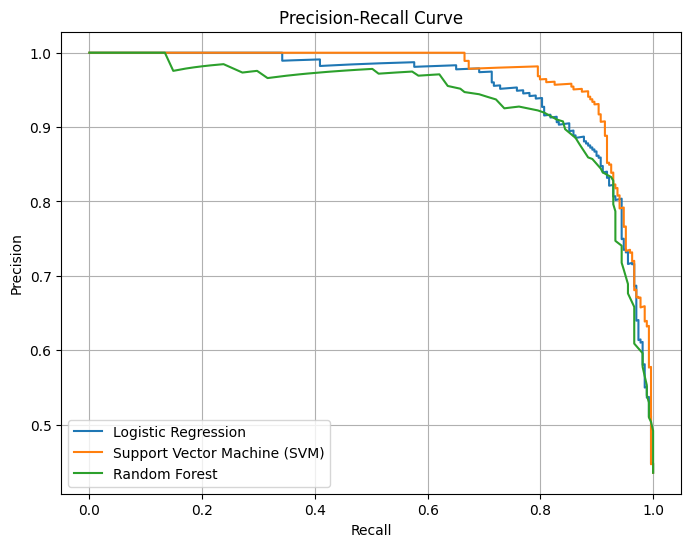

In [16]:

# Plot Precision-Recall Curve for best models
plt.figure(figsize=(8, 6))
for name, result in results.items():
    y_prob = result["model"].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

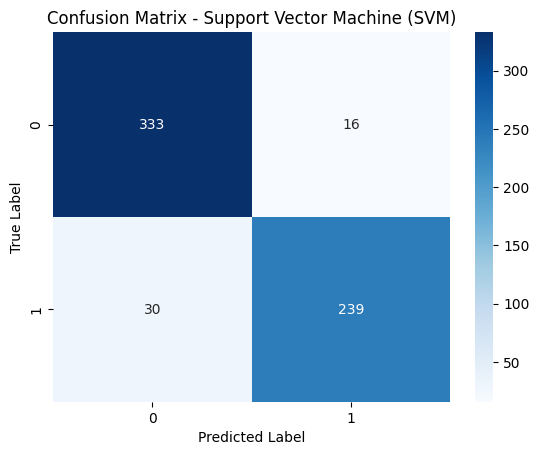

In [17]:
# Confusion Matrix Heatmap for the best model (Change key to desired model)
best_model = "Support Vector Machine (SVM)"  # Change to the best-performing model
sns.heatmap(results[best_model]["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {best_model}")
plt.show()

Summary from above Heatmap
1. A high number of True Negatives (333) indicates that the model is very good at correctly identifying real images.
2. A high number of True Positives (239) suggests that the model is fairly effective at identifying AI-generated images.